- 100 runs of 500 iterations of 3 algorithms performing 3 functions : 
    - (1+1) with success rule
    - (μ+λ) with linear decay 
    - (1+λ)-σ-SA 

## Sphere function

In [248]:
import numpy as np
from scipy.stats import wilcoxon
import random
import matplotlib.pyplot as plt
import math

np.random.seed(42)

def success_rule(x, x_, sigma, fit_f, d):
    if fit_f(x_) <= fit_f(x):
        x = x_
        sigma = sigma * math.exp(4/5/d)
    else:
        sigma = sigma * math.exp(-1/5/d)
    return x, sigma

def sphere_function(x):
    return np.dot(x, x)

def crossover(rho, pop):
    subsample = random.sample(pop, rho)
    x_s = []
    for sample in subsample:
        x_s.append(sample[0])
    average = np.mean(np.array(x_s), axis=0)
    return average

def select_mu_best(population, mu):
    sorted_pop = sorted(population, key=lambda x: x[1])
    mu_best = sorted_pop[:mu]
    return mu_best

###################
#     PARAMS
##################
function = sphere_function
sigma = 1.
###################

# Function to run the 1+1 with success rule algorithm for a given number of steps

def run_one_plus_one(dim, sigma, func, max_iterations=500, num_runs=100):
    fitted_values = []
    for _ in range(num_runs):
    
    
        x = np.random.uniform(0, 10, size=dim)  # Initialize x for each n_dim
        count = 0
        convergence_history = []  # List to store convergence history for current n_dim
        
        while count < max_iterations:   
            x_ = x + sigma * np.random.normal(0, 1, dim)
            x, sigma = success_rule(x, x_, sigma, func, dim)  
            convergence_history.append(func(x))  # Store convergence data for current iteration
            count += 1   
        
        fitted_value = min(convergence_history)  # Compute the best fitted value after 500 steps
        fitted_values.append(fitted_value)
        
    return fitted_values

# Function to run the (μ + λ) with decay algorithm for a given number of steps

def run_mu_rho_lambda_selection(dim, sigma, func, max_iterations=500, num_runs=100):
    fitted_values = []
    for _ in range(num_runs):
        # Your implementation of (μ/ρ, λ)-selection Evolution Strategy algorithm goes here
        
        mu = 10
        lam = 20
        rho = 5

        fitness = func

        # initialize population
        pop = []
        for k in range(mu):
            x = np.random.normal(0, 5, dim)
            pop.append((x, fitness(x)))

        iter = 0
        fitness_values = []
        while iter < max_iterations:
            # adapt sigma during the run (linearly)
            sigma *= 0.99
            # create children
            children = []
            for k in range(lam):
                x_k = crossover(rho, pop)
                x_k = x_k + sigma * np.random.normal(0, 1, len(x_k))
                children.append((x_k, fitness(x_k)))
            # select mu best from children and parents
            pop = select_mu_best(pop + children, mu)
            fitness_values.append(pop[0][1])
            iter += 1      
            
        # Run the algorithm for the specified number of steps
        fitted_value = min(fitness_values)  # Compute the best fitted value after 500 steps
        fitted_values.append(fitted_value)
    return fitted_values

# Function to run the (1+λ) Evolution Strategy algorithm for a given number of steps
def run_one_plus_lambda(dim, func, max_iterations=500, num_runs=100):
    fitted_values = []
    for _ in range(num_runs):
        
        #Implementation of (1,λ)-SA algorithm 
        
        # Initialization
        lambda_ = 10
        x = np.random.normal(0, 5, dim)
        tau = 1.0 / np.sqrt(dim)
        sigma = 1.

        # Lists to store convergence data
        convergence_data = []

        # Repeat until termination
        for iteration in range(max_iterations):
            offspring_fitness = []
            offspring = []

            # Mutation and offspring generation
            for k in range(lambda_):
                eps = tau * np.random.normal(0, 1, 1)
                z = np.random.randn(dim)
                sigma_k = sigma * np.exp(eps)
                x_k = x + sigma_k * z

                offspring.append((x_k, sigma_k))
                offspring_fitness.append(func(x_k))

            # Selection: Choose the best offspring
            best_index = np.argmin(offspring_fitness)
            best_x, best_sigma = offspring[best_index]
            convergence_data.append(min(offspring_fitness))

            # Update x and sigma
            x = best_x
            sigma = best_sigma

        # Run the algorithm for the specified number of steps
        fitted_value = min(convergence_data) # Compute the best fitted value after 500 steps
        fitted_values.append(fitted_value)
    return fitted_values

# Run each algorithm and collect the fitted values for comparison
dim_values = [5, 10, 20]
one_plus_one_values = []
mu_rho_lambda_values = []
one_plus_lambda_values = []

paired_dist_1_1_mu_rho_lambda = []
paired_dist_1_1_one_plus_lambda = []
paired_dist_mu_rho_lambda_one_plus_lambda = []


for i, dim in enumerate(dim_values):
    one_plus_one_values.append(run_one_plus_one(dim, sigma, function))
    mu_rho_lambda_values.append(run_mu_rho_lambda_selection(dim, sigma, function))
    one_plus_lambda_values.append(run_one_plus_lambda(dim, function))
    
    paired_dist_1_1_mu_rho_lambda.append((one_plus_one_values[i], mu_rho_lambda_values[i]))
    paired_dist_1_1_one_plus_lambda.append((one_plus_one_values[i], one_plus_lambda_values[i]))
    paired_dist_mu_rho_lambda_one_plus_lambda.append((mu_rho_lambda_values[i], one_plus_lambda_values[i]))
    

# Perform Wilcoxon signed-rank test for each pair of algorithms
for dim, dim_value in enumerate(dim_values):
    print(f"Dimension: {dim_value}")
    print("Wilcoxon Signed-Rank Test:")
    print("one_plus_one vs. (μ/ρ, λ):")
    w_statistic, p_value = wilcoxon(one_plus_one_values[dim], mu_rho_lambda_values[dim])
    
    print(f"  W statistic: {w_statistic}")
    print(f"  p-value: {p_value}")
    print("one_plus_one vs. (1+λ):")
    w_statistic, p_value = wilcoxon(one_plus_one_values[dim], one_plus_lambda_values[dim])
    
    print(f"  W statistic: {w_statistic}")
    print(f"  p-value: {p_value}")
    print("(μ/ρ, λ) vs. (1+λ):")
    w_statistic, p_value = wilcoxon(mu_rho_lambda_values[dim], one_plus_lambda_values[dim])
    
    print(f"  W statistic: {w_statistic}")
    print(f"  p-value: {p_value}")
    print()


Dimension: 5
Wilcoxon Signed-Rank Test:
one_plus_one vs. (μ/ρ, λ):
  W statistic: 0.0
  p-value: 3.896559845095909e-18
one_plus_one vs. (1+λ):
  W statistic: 0.0
  p-value: 3.896559845095909e-18
(μ/ρ, λ) vs. (1+λ):
  W statistic: 0.0
  p-value: 3.896559845095909e-18

Dimension: 10
Wilcoxon Signed-Rank Test:
one_plus_one vs. (μ/ρ, λ):
  W statistic: 1.0
  p-value: 4.0161556854627e-18
one_plus_one vs. (1+λ):
  W statistic: 0.0
  p-value: 3.896559845095909e-18
(μ/ρ, λ) vs. (1+λ):
  W statistic: 0.0
  p-value: 3.896559845095909e-18

Dimension: 20
Wilcoxon Signed-Rank Test:
one_plus_one vs. (μ/ρ, λ):
  W statistic: 1.0
  p-value: 4.0161556854627e-18
one_plus_one vs. (1+λ):
  W statistic: 0.0
  p-value: 3.896559845095909e-18
(μ/ρ, λ) vs. (1+λ):
  W statistic: 0.0
  p-value: 3.896559845095909e-18



Mean (1+1)    7.802600418359998e-06,    Mean (μ+λ):    5.427157212532556

Mean (1+1)    7.802600418359998e-06,    Mean (1+λ)-σ-SA:    2.66537451317026e-67

Mean (μ+λ)    5.427157212532556,        Mean (1+λ)-σ-SA:    2.66537451317026e-67


Mean (1+1)    0.011831277629760995,    Mean (μ+λ):    15.599155376000747

Mean (1+1)    0.011831277629760995,    Mean (1+λ)-σ-SA:    4.145232441794193e-35

Mean (μ+λ)    15.599155376000747,        Mean (1+λ)-σ-SA:    4.145232441794193e-35


Mean (1+1)    1.288993210137417,    Mean (μ+λ):    42.28696614243731

Mean (1+1)    1.288993210137417,    Mean (1+λ)-σ-SA:    2.5599054194412364e-16

Mean (μ+λ)    42.28696614243731,        Mean (1+λ)-σ-SA:    2.5599054194412364e-16




/var/folders/5y/mgq2t6sj3cv0x0kl7t394f9w0000gn/T/ipykernel_16877/2786163590.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


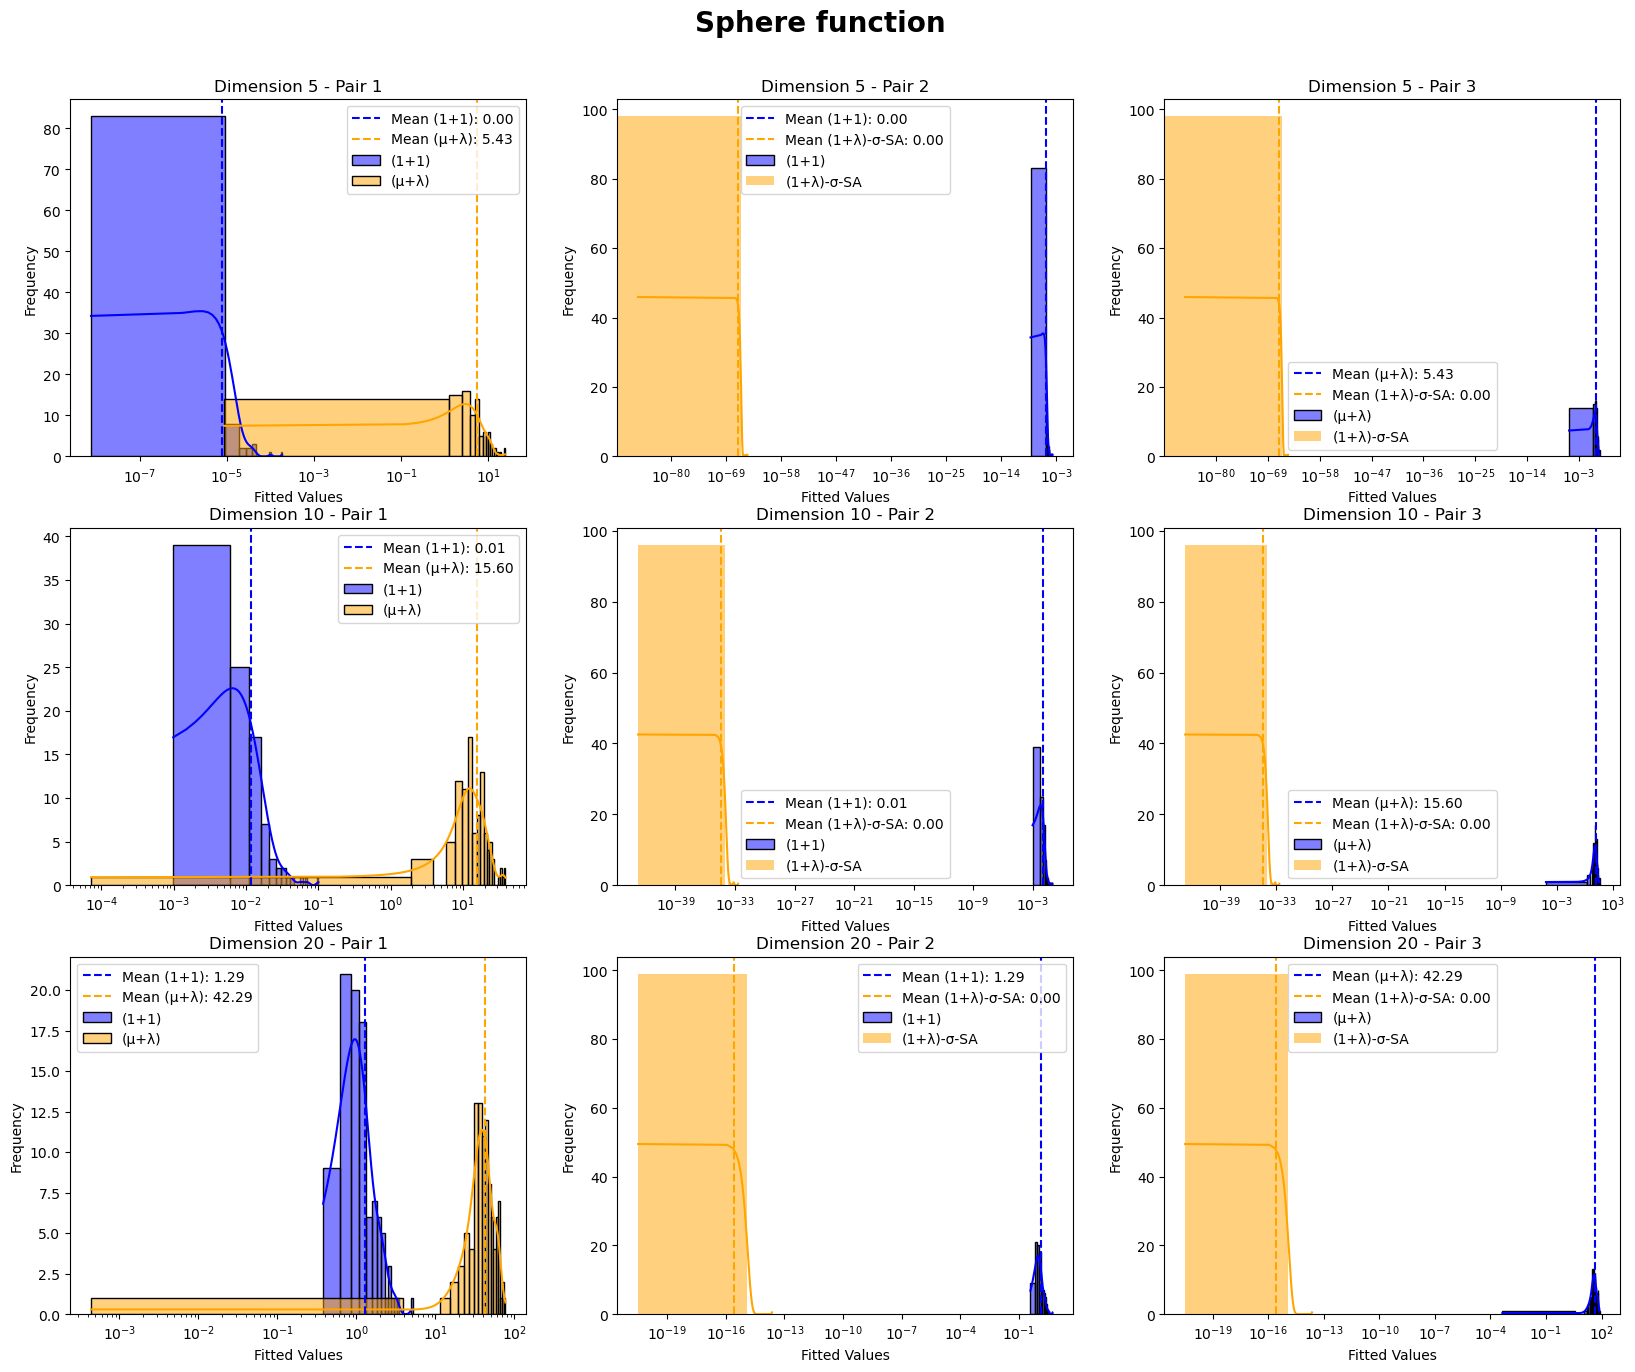

In [255]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the paired distributions for each pair for each dimension
paired_distributions = [
    paired_dist_1_1_mu_rho_lambda,
    paired_dist_1_1_one_plus_lambda,
    paired_dist_mu_rho_lambda_one_plus_lambda
]

# Define the number of bins for the histograms
n_bins = 20

# Create subplots for each pair of distributions
fig, axs = plt.subplots(nrows=len(dim_values), ncols=len(paired_distributions), figsize=(20, 15),
                        gridspec_kw={'top': 0.92})

# Loop through each dimension and each pair of distributions
for dim_idx, dim in enumerate(dim_values):
    for pair_idx, pair in enumerate(paired_distributions):
        ax = axs[dim_idx, pair_idx]
        
        
        if pair_idx == 0: 
            sns.histplot(pair[dim_idx][0], bins=n_bins, kde=True, color='blue', ax=ax, label='(1+1)', alpha=0.5)
            sns.histplot(pair[dim_idx][1], bins=n_bins, kde=True, color='orange', ax=ax, label='(μ+λ)', alpha=0.5)

            # Calculate and plot mean lines
            mean_1_1 = np.mean(pair[dim_idx][0])
            mean_mu_lambda = np.mean(pair[dim_idx][1])
            
            print(f'Mean (1+1)    {mean_1_1},    Mean (μ+λ):    {mean_mu_lambda}')
            print("")
            
            ax.axvline(mean_1_1, color='blue', linestyle='--', label=f'Mean (1+1): {mean_1_1:.2f}')
            ax.axvline(mean_mu_lambda, color='orange', linestyle='--', label=f'Mean (μ+λ): {mean_mu_lambda:.2f}')

            # Set labels and titles
            ax.set_xlabel('Fitted Values')
            ax.set_ylabel('Frequency')
            ax.set_title(f"Dimension {dim} - Pair {pair_idx + 1}")
            ax.legend()

            # Rescale x-axis with logarithmic scale
            ax.set_xscale('log')
        elif pair_idx == 1: 
            sns.histplot(pair[dim_idx][0], bins=n_bins, kde=True, color='blue', ax=ax, label='(1+1)', alpha=0.5)
            sns.histplot(pair[dim_idx][1], bins=n_bins, kde=True, color='orange', ax=ax, label='(1+λ)-σ-SA', alpha=0.5)

            # Calculate and plot mean lines
            mean_1_1 = np.mean(pair[dim_idx][0])
            mean_mu_lambda = np.mean(pair[dim_idx][1])
            
            print(f'Mean (1+1)    {mean_1_1},    Mean (1+λ)-σ-SA:    {mean_mu_lambda}')
            print("")
            
            ax.axvline(mean_1_1, color='blue', linestyle='--', label=f'Mean (1+1): {mean_1_1:.2f}')
            ax.axvline(mean_mu_lambda, color='orange', linestyle='--', label=f'Mean (1+λ)-σ-SA: {mean_mu_lambda:.2f}')

            # Set labels and titles
            ax.set_xlabel('Fitted Values')
            ax.set_ylabel('Frequency')
            ax.set_title(f"Dimension {dim} - Pair {pair_idx + 1}")
            ax.legend()

            # Rescale x-axis with logarithmic scale
            ax.set_xscale('log')
        else:
            sns.histplot(pair[dim_idx][0], bins=n_bins, kde=True, color='blue', ax=ax, label='(μ+λ)', alpha=0.5)
            sns.histplot(pair[dim_idx][1], bins=n_bins, kde=True, color='orange', ax=ax, label='(1+λ)-σ-SA', alpha=0.5)

            # Calculate and plot mean lines
            mean_1_1 = np.mean(pair[dim_idx][0])
            mean_mu_lambda = np.mean(pair[dim_idx][1])
            
            
            print(f'Mean (μ+λ)    {mean_1_1},        Mean (1+λ)-σ-SA:    {mean_mu_lambda}')
            print("")
            print("")
            
            ax.axvline(mean_1_1, color='blue', linestyle='--', label=f'Mean (μ+λ): {mean_1_1:.2f}')
            ax.axvline(mean_mu_lambda, color='orange', linestyle='--', label=f'Mean (1+λ)-σ-SA: {mean_mu_lambda:.2f}')

            # Set labels and titles
            ax.set_xlabel('Fitted Values')
            ax.set_ylabel('Frequency')
            ax.set_title(f"Dimension {dim} - Pair {pair_idx + 1}")
            ax.legend()

            # Rescale x-axis with logarithmic scale
            ax.set_xscale('log')

    
# Adjust layout
fig.tight_layout()
fig.suptitle('Sphere function', fontsize=20, fontweight='bold')

# Show the plot
plt.show()


# (1+lambda) - 1
# 1+1 - 2
# (mu+lambda) - 3 

In [236]:
import numpy as np
from scipy.stats import wilcoxon
import random
import matplotlib.pyplot as plt
import math

np.random.seed(42)

def success_rule(x, x_, sigma, fit_f, d):
    if fit_f(x_) <= fit_f(x):
        x = x_
        sigma = sigma * math.exp(4/5/d)
    else:
        sigma = sigma * math.exp(-1/5/d)
    return x, sigma

def sphere_function(x):
    return np.dot(x, x)

def rastrigin_function(x):
    """Rastrigin function: f(x) = A * n + sum(x_i^2 - A * cos(2 * pi * x_i)), where A = 10, and -5.12 <= x_i <= 5.12."""
    A = 10
    return A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x))

def rosenbrock_function(x):
    """Rosenbrock function: f(x) = sum(100 * (x_{i+1} - x_i^2)^2 + (1 - x_i)^2), where -5 <= x_i <= 10."""
    return np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)


def crossover(rho, pop):
    subsample = random.sample(pop, rho)
    x_s = []
    for sample in subsample:
        x_s.append(sample[0])
    average = np.mean(np.array(x_s), axis=0)
    return average

def select_mu_best(population, mu):
    sorted_pop = sorted(population, key=lambda x: x[1])
    mu_best = sorted_pop[:mu]
    return mu_best

###################
#     PARAMS
##################
function = rosenbrock_function
sigma = 1.
###################

# Function to run the 1+1 with success rule algorithm for a given number of steps


def run_one_plus_one(dim, sigma, func, max_iterations=500, num_runs=100):
    fitted_values = []
    for _ in range(num_runs):
    
        x = np.random.uniform(0, 10, size=dim)  # Initialize x for each n_dim
        count = 0
        convergence_history = []  # List to store convergence history for current n_dim
        
        while count < max_iterations:  
            x_ = x + sigma * np.random.normal(0, 1, dim)
            x, sigma = success_rule(x, x_, sigma, func, dim) 
            convergence_history.append(func(x))  # Store convergence data for current iteration
            count += 1   
        
        fitted_value = min(convergence_history)  # Compute the best fitted value after 500 steps
        fitted_values.append(fitted_value)
        
    return fitted_values

# Function to run the (μ + λ) with decay algorithm for a given number of steps

def run_mu_rho_lambda_selection(dim, sigma, func, max_iterations=500, num_runs=100):
    fitted_values = []
    for _ in range(num_runs):
        # Your implementation of (μ/ρ, λ)-selection Evolution Strategy algorithm goes here
        
        mu = 10
        lam = 20
        rho = 5

        fitness = func

        # initialize population
        pop = []
        for k in range(mu):
            x = np.random.normal(0, 5, dim)
            pop.append((x, fitness(x)))

        iter = 0
        fitness_values = []
        while iter < max_iterations:
            # adapt sigma during the run (linearly)
            sigma *= 0.99
            # create children
            children = []
            for k in range(lam):
                x_k = crossover(rho, pop)
                x_k = x_k + sigma * np.random.normal(0, 1, len(x_k))
                children.append((x_k, fitness(x_k)))
            # select mu best from children and parents
            pop = select_mu_best(pop + children, mu)
            fitness_values.append(pop[0][1])
            iter += 1      
            
        # Run the algorithm for the specified number of steps
        fitted_value = min(fitness_values)  # Compute the best fitted value after 500 steps
        fitted_values.append(fitted_value)
    return fitted_values

# Function to run the (1+λ) Evolution Strategy algorithm for a given number of steps
def run_one_plus_lambda(dim, func, max_iterations=500, num_runs=100):
    fitted_values = []
    for _ in range(num_runs):
        
        #Implementation of (1,λ)-SA algorithm 
        
        # Initialization
        lambda_ = 10
        x = np.random.normal(0, 5, dim)
        tau = 1.0 / np.sqrt(dim)
        sigma = 1.

        # Lists to store convergence data
        convergence_data = []

        # Repeat until termination
        for iteration in range(max_iterations):
            offspring_fitness = []
            offspring = []

            # Mutation and offspring generation
            for k in range(lambda_):
                eps = tau * np.random.normal(0, 1, 1)
                z = np.random.randn(dim)
                sigma_k = sigma * np.exp(eps)
                x_k = x + sigma_k * z

                offspring.append((x_k, sigma_k))
                offspring_fitness.append(func(x_k))

            # Selection: Choose the best offspring
            best_index = np.argmin(offspring_fitness)
            best_x, best_sigma = offspring[best_index]
            convergence_data.append(min(offspring_fitness))

            # Update x and sigma
            x = best_x
            sigma = best_sigma

        # Run the algorithm for the specified number of steps
        fitted_value = min(convergence_data) # Compute the best fitted value after 500 steps
        fitted_values.append(fitted_value)
    return fitted_values

# Run each algorithm and collect the fitted values for comparison
dim_values = [5, 10, 20]
one_plus_one_values = []
mu_rho_lambda_values = []
one_plus_lambda_values = []

paired_dist_1_1_mu_rho_lambda = []
paired_dist_1_1_one_plus_lambda = []
paired_dist_mu_rho_lambda_one_plus_lambda = []


for i, dim in enumerate(dim_values):
    one_plus_one_values.append(run_one_plus_one(dim, sigma, function))
    mu_rho_lambda_values.append(run_mu_rho_lambda_selection(dim, sigma, function))
    one_plus_lambda_values.append(run_one_plus_lambda(dim, function))
    
    paired_dist_1_1_mu_rho_lambda.append((one_plus_one_values[i], mu_rho_lambda_values[i]))
    paired_dist_1_1_one_plus_lambda.append((one_plus_one_values[i], one_plus_lambda_values[i]))
    paired_dist_mu_rho_lambda_one_plus_lambda.append((mu_rho_lambda_values[i], one_plus_lambda_values[i]))
    

# Perform Wilcoxon signed-rank test for each pair of algorithms
for dim, dim_value in enumerate(dim_values):
    print(f"Dimension: {dim_value}")
    print("Wilcoxon Signed-Rank Test:")
    print("one_plus_one vs. (μ/ρ, λ):")
    w_statistic, p_value = wilcoxon(one_plus_one_values[dim], mu_rho_lambda_values[dim])
    
    print(f"  W statistic: {w_statistic}")
    print(f"  p-value: {p_value}")
    print("one_plus_one vs. (1+λ):")
    w_statistic, p_value = wilcoxon(one_plus_one_values[dim], one_plus_lambda_values[dim])
    
    print(f"  W statistic: {w_statistic}")
    print(f"  p-value: {p_value}")
    print("(μ/ρ, λ) vs. (1+λ):")
    w_statistic, p_value = wilcoxon(mu_rho_lambda_values[dim], one_plus_lambda_values[dim])
    
    print(f"  W statistic: {w_statistic}")
    print(f"  p-value: {p_value}")
    print()



Dimension: 5
Wilcoxon Signed-Rank Test:
one_plus_one vs. (μ/ρ, λ):
  W statistic: 198.0
  p-value: 1.234309221920007e-15
one_plus_one vs. (1+λ):
  W statistic: 828.0
  p-value: 5.384309387228941e-09
(μ/ρ, λ) vs. (1+λ):
  W statistic: 26.0
  p-value: 8.519072542858556e-18

Dimension: 10
Wilcoxon Signed-Rank Test:
one_plus_one vs. (μ/ρ, λ):
  W statistic: 3.0
  p-value: 4.2663227307182344e-18
one_plus_one vs. (1+λ):
  W statistic: 616.0
  p-value: 5.246687687977604e-11
(μ/ρ, λ) vs. (1+λ):
  W statistic: 0.0
  p-value: 3.896559845095909e-18

Dimension: 20
Wilcoxon Signed-Rank Test:
one_plus_one vs. (μ/ρ, λ):
  W statistic: 1.0
  p-value: 4.0161556854627e-18
one_plus_one vs. (1+λ):
  W statistic: 84.0
  p-value: 4.7408945782600864e-17
(μ/ρ, λ) vs. (1+λ):
  W statistic: 0.0
  p-value: 3.896559845095909e-18



Mean (1+1)    62.875408925017965,    Mean (μ+λ):    1731.4565284817102

Mean (1+1)    62.875408925017965,    Mean (1+λ)-σ-SA:    13.093093135283238

Mean (μ+λ)    1731.4565284817102,        Mean (1+λ)-σ-SA:    13.093093135283238


Mean (1+1)    102.52808043906325,    Mean (μ+λ):    6695.330717084728

Mean (1+1)    102.52808043906325,    Mean (1+λ)-σ-SA:    21.91907821536341

Mean (μ+λ)    6695.330717084728,        Mean (1+λ)-σ-SA:    21.91907821536341


Mean (1+1)    470.73326511007514,    Mean (μ+λ):    24702.57448059835

Mean (1+1)    470.73326511007514,    Mean (1+λ)-σ-SA:    58.397257090283176

Mean (μ+λ)    24702.57448059835,        Mean (1+λ)-σ-SA:    58.397257090283176




/var/folders/5y/mgq2t6sj3cv0x0kl7t394f9w0000gn/T/ipykernel_16877/1876983271.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


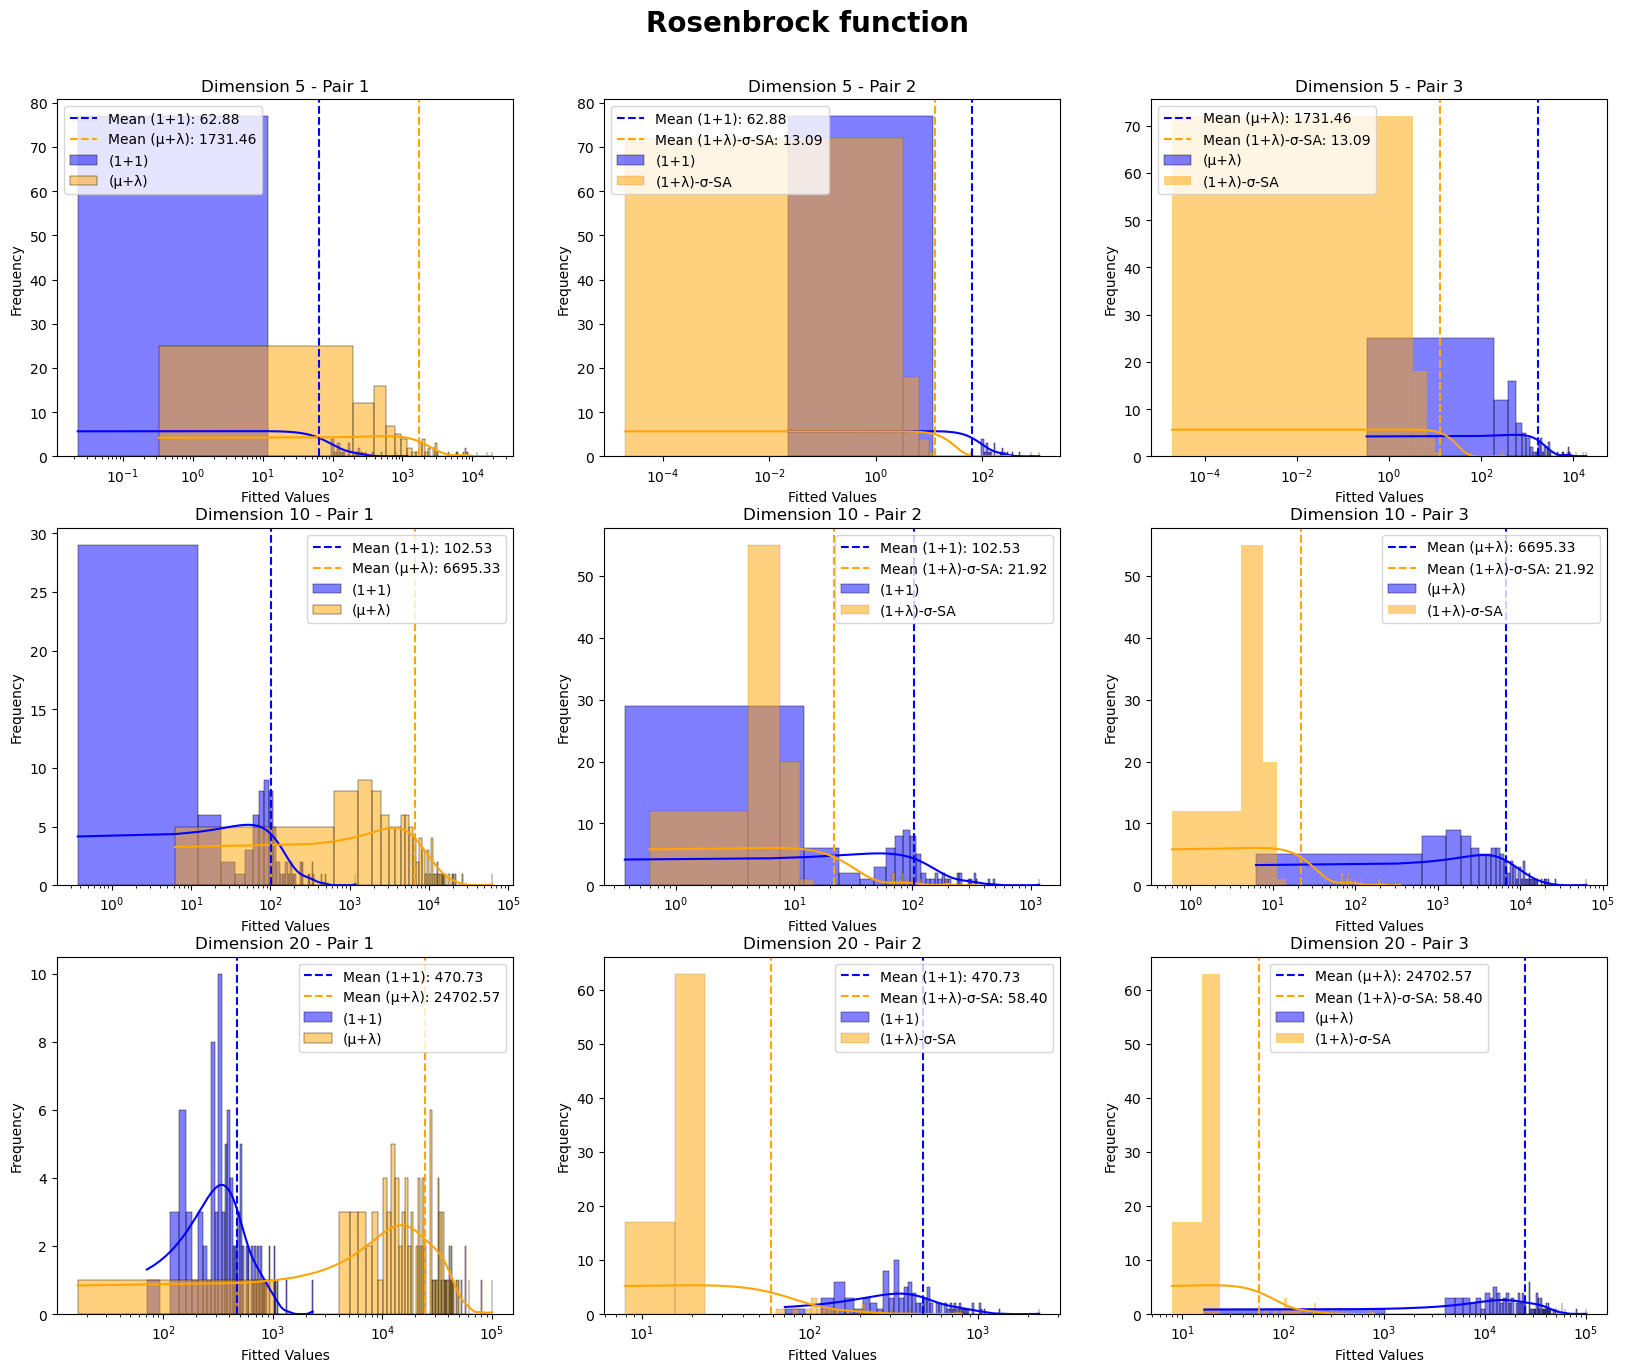

In [246]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the paired distributions for each pair for each dimension
paired_distributions = [
    paired_dist_1_1_mu_rho_lambda,
    paired_dist_1_1_one_plus_lambda,
    paired_dist_mu_rho_lambda_one_plus_lambda
]

# Define the number of bins for the histograms
n_bins = 100

# Create subplots for each pair of distributions
fig, axs = plt.subplots(nrows=len(dim_values), ncols=len(paired_distributions), figsize=(20, 15),
                       gridspec_kw={'top': 0.92})

# Loop through each dimension and each pair of distributions
for dim_idx, dim in enumerate(dim_values):
    for pair_idx, pair in enumerate(paired_distributions):
        ax = axs[dim_idx, pair_idx]
        
        
        if pair_idx == 0: 
            sns.histplot(pair[dim_idx][0], bins=n_bins, kde=True, color='blue', ax=ax, label='(1+1)', alpha=0.5)
            sns.histplot(pair[dim_idx][1], bins=n_bins, kde=True, color='orange', ax=ax, label='(μ+λ)', alpha=0.5)

            # Calculate and plot mean lines
            mean_1_1 = np.mean(pair[dim_idx][0])
            mean_mu_lambda = np.mean(pair[dim_idx][1])
            
            print(f'Mean (1+1)    {mean_1_1},    Mean (μ+λ):    {mean_mu_lambda}')
            print("")
            
            ax.axvline(mean_1_1, color='blue', linestyle='--', label=f'Mean (1+1): {mean_1_1:.2f}')
            ax.axvline(mean_mu_lambda, color='orange', linestyle='--', label=f'Mean (μ+λ): {mean_mu_lambda:.2f}')

            # Set labels and titles
            ax.set_xlabel('Fitted Values')
            ax.set_ylabel('Frequency')
            ax.set_title(f"Dimension {dim} - Pair {pair_idx + 1}")
            ax.legend()

            # Rescale x-axis with logarithmic scale
            ax.set_xscale('log')
        elif pair_idx == 1: 
            sns.histplot(pair[dim_idx][0], bins=n_bins, kde=True, color='blue', ax=ax, label='(1+1)', alpha=0.5)
            sns.histplot(pair[dim_idx][1], bins=n_bins, kde=True, color='orange', ax=ax, label='(1+λ)-σ-SA', alpha=0.5)

            # Calculate and plot mean lines
            mean_1_1 = np.mean(pair[dim_idx][0])
            mean_mu_lambda = np.mean(pair[dim_idx][1])
            
            print(f'Mean (1+1)    {mean_1_1},    Mean (1+λ)-σ-SA:    {mean_mu_lambda}')
            print("")
            
            ax.axvline(mean_1_1, color='blue', linestyle='--', label=f'Mean (1+1): {mean_1_1:.2f}')
            ax.axvline(mean_mu_lambda, color='orange', linestyle='--', label=f'Mean (1+λ)-σ-SA: {mean_mu_lambda:.2f}')

            # Set labels and titles
            ax.set_xlabel('Fitted Values')
            ax.set_ylabel('Frequency')
            ax.set_title(f"Dimension {dim} - Pair {pair_idx + 1}")
            ax.legend()

            # Rescale x-axis with logarithmic scale
            ax.set_xscale('log')
        else:
            sns.histplot(pair[dim_idx][0], bins=n_bins, kde=True, color='blue', ax=ax, label='(μ+λ)', alpha=0.5)
            sns.histplot(pair[dim_idx][1], bins=n_bins, kde=True, color='orange', ax=ax, label='(1+λ)-σ-SA', alpha=0.5)

            # Calculate and plot mean lines
            mean_1_1 = np.mean(pair[dim_idx][0])
            mean_mu_lambda = np.mean(pair[dim_idx][1])
            
            
            print(f'Mean (μ+λ)    {mean_1_1},        Mean (1+λ)-σ-SA:    {mean_mu_lambda}')
            print("")
            print("")
            
            ax.axvline(mean_1_1, color='blue', linestyle='--', label=f'Mean (μ+λ): {mean_1_1:.2f}')
            ax.axvline(mean_mu_lambda, color='orange', linestyle='--', label=f'Mean (1+λ)-σ-SA: {mean_mu_lambda:.2f}')

            # Set labels and titles
            ax.set_xlabel('Fitted Values')
            ax.set_ylabel('Frequency')
            ax.set_title(f"Dimension {dim} - Pair {pair_idx + 1}")
            ax.legend()

            # Rescale x-axis with logarithmic scale
            ax.set_xscale('log')

    
# Adjust layout
fig.tight_layout()
fig.suptitle('Rosenbrock function', fontsize=20, fontweight='bold')
# Show the plot
plt.show()


# (1+lambda) - 1
# 1+1 - 2
# (mu+lambda) - 3 



In [256]:
import numpy as np
from scipy.stats import wilcoxon
import random
import matplotlib.pyplot as plt
import math

np.random.seed(42)

def success_rule(x, x_, sigma, fit_f, d):
    if fit_f(x_) <= fit_f(x):
        x = x_
        sigma = sigma * math.exp(4/5/d)
    else:
        sigma = sigma * math.exp(-1/5/d)
    return x, sigma

def sphere_function(x):
    return np.dot(x, x)

def rastrigin_function(x):
    """Rastrigin function: f(x) = A * n + sum(x_i^2 - A * cos(2 * pi * x_i)), where A = 10, and -5.12 <= x_i <= 5.12."""
    A = 10
    return A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x))

def rosenbrock_function(x):
    """Rosenbrock function: f(x) = sum(100 * (x_{i+1} - x_i^2)^2 + (1 - x_i)^2), where -5 <= x_i <= 10."""
    return np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)


def crossover(rho, pop):
    subsample = random.sample(pop, rho)
    x_s = []
    for sample in subsample:
        x_s.append(sample[0])
    average = np.mean(np.array(x_s), axis=0)
    return average

def select_mu_best(population, mu):
    sorted_pop = sorted(population, key=lambda x: x[1])
    mu_best = sorted_pop[:mu]
    return mu_best

###################
#     PARAMS
##################
function = rastrigin_function
sigma = 1.
###################

# Function to run the 1+1 with success rule algorithm for a given number of steps


def run_one_plus_one(dim, sigma, func, max_iterations=500, num_runs=100):
    fitted_values = []
    for _ in range(num_runs):
    
        x = np.random.uniform(0, 10, size=dim)  # Initialize x for each n_dim
        count = 0
        convergence_history = []  # List to store convergence history for current n_dim
        
        while count < max_iterations:  
            x_ = x + sigma * np.random.normal(0, 1, dim)
            x, sigma = success_rule(x, x_, sigma, func, dim) 
            convergence_history.append(func(x))  # Store convergence data for current iteration
            count += 1   
        
        fitted_value = min(convergence_history)  # Compute the best fitted value after 500 steps
        fitted_values.append(fitted_value)
        
    return fitted_values

# Function to run the (μ + λ) with decay algorithm for a given number of steps

def run_mu_rho_lambda_selection(dim, sigma, func, max_iterations=500, num_runs=100):
    fitted_values = []
    for _ in range(num_runs):
        # Your implementation of (μ/ρ, λ)-selection Evolution Strategy algorithm goes here
        
        mu = 10
        lam = 20
        rho = 5

        fitness = func

        # initialize population
        pop = []
        for k in range(mu):
            x = np.random.normal(0, 5, dim)
            pop.append((x, fitness(x)))

        iter = 0
        fitness_values = []
        while iter < max_iterations:
            # adapt sigma during the run (linearly)
            sigma *= 0.99
            # create children
            children = []
            for k in range(lam):
                x_k = crossover(rho, pop)
                x_k = x_k + sigma * np.random.normal(0, 1, len(x_k))
                children.append((x_k, fitness(x_k)))
            # select mu best from children and parents
            pop = select_mu_best(pop + children, mu)
            fitness_values.append(pop[0][1])
            iter += 1      
            
        # Run the algorithm for the specified number of steps
        fitted_value = min(fitness_values)  # Compute the best fitted value after 500 steps
        fitted_values.append(fitted_value)
    return fitted_values

# Function to run the (1+λ) Evolution Strategy algorithm for a given number of steps
def run_one_plus_lambda(dim, func, max_iterations=500, num_runs=100):
    fitted_values = []
    for _ in range(num_runs):
        
        #Implementation of (1,λ)-SA algorithm 
        
        # Initialization
        lambda_ = 10
        x = np.random.normal(0, 5, dim)
        tau = 1.0 / np.sqrt(dim)
        sigma = 1.

        # Lists to store convergence data
        convergence_data = []

        # Repeat until termination
        for iteration in range(max_iterations):
            offspring_fitness = []
            offspring = []

            # Mutation and offspring generation
            for k in range(lambda_):
                eps = tau * np.random.normal(0, 1, 1)
                z = np.random.randn(dim)
                sigma_k = sigma * np.exp(eps)
                x_k = x + sigma_k * z

                offspring.append((x_k, sigma_k))
                offspring_fitness.append(func(x_k))

            # Selection: Choose the best offspring
            best_index = np.argmin(offspring_fitness)
            best_x, best_sigma = offspring[best_index]
            convergence_data.append(min(offspring_fitness))

            # Update x and sigma
            x = best_x
            sigma = best_sigma

        # Run the algorithm for the specified number of steps
        fitted_value = min(convergence_data) # Compute the best fitted value after 500 steps
        fitted_values.append(fitted_value)
    return fitted_values

# Run each algorithm and collect the fitted values for comparison
dim_values = [5, 10, 20]
one_plus_one_values = []
mu_rho_lambda_values = []
one_plus_lambda_values = []

paired_dist_1_1_mu_rho_lambda = []
paired_dist_1_1_one_plus_lambda = []
paired_dist_mu_rho_lambda_one_plus_lambda = []


for i, dim in enumerate(dim_values):
    one_plus_one_values.append(run_one_plus_one(dim, sigma, function))
    mu_rho_lambda_values.append(run_mu_rho_lambda_selection(dim, sigma, function))
    one_plus_lambda_values.append(run_one_plus_lambda(dim, function))
    
    paired_dist_1_1_mu_rho_lambda.append((one_plus_one_values[i], mu_rho_lambda_values[i]))
    paired_dist_1_1_one_plus_lambda.append((one_plus_one_values[i], one_plus_lambda_values[i]))
    paired_dist_mu_rho_lambda_one_plus_lambda.append((mu_rho_lambda_values[i], one_plus_lambda_values[i]))
    

# Perform Wilcoxon signed-rank test for each pair of algorithms
for dim, dim_value in enumerate(dim_values):
    print(f"Dimension: {dim_value}")
    print("Wilcoxon Signed-Rank Test:")
    print("one_plus_one vs. (μ/ρ, λ):")
    w_statistic, p_value = wilcoxon(one_plus_one_values[dim], mu_rho_lambda_values[dim])
    
    print(f"  W statistic: {w_statistic}")
    print(f"  p-value: {p_value}")
    print("one_plus_one vs. (1+λ):")
    w_statistic, p_value = wilcoxon(one_plus_one_values[dim], one_plus_lambda_values[dim])
    
    print(f"  W statistic: {w_statistic}")
    print(f"  p-value: {p_value}")
    print("(μ/ρ, λ) vs. (1+λ):")
    w_statistic, p_value = wilcoxon(mu_rho_lambda_values[dim], one_plus_lambda_values[dim])
    
    print(f"  W statistic: {w_statistic}")
    print(f"  p-value: {p_value}")
    print()



Dimension: 5
Wilcoxon Signed-Rank Test:
one_plus_one vs. (μ/ρ, λ):
  W statistic: 0.0
  p-value: 3.896559845095909e-18
one_plus_one vs. (1+λ):
  W statistic: 10.0
  p-value: 5.269204481546392e-18
(μ/ρ, λ) vs. (1+λ):
  W statistic: 2427.0
  p-value: 0.7361501939167332

Dimension: 10
Wilcoxon Signed-Rank Test:
one_plus_one vs. (μ/ρ, λ):
  W statistic: 0.0
  p-value: 3.896559845095909e-18
one_plus_one vs. (1+λ):
  W statistic: 0.0
  p-value: 3.896559845095909e-18
(μ/ρ, λ) vs. (1+λ):
  W statistic: 1840.0
  p-value: 0.018510122267142947

Dimension: 20
Wilcoxon Signed-Rank Test:
one_plus_one vs. (μ/ρ, λ):
  W statistic: 0.0
  p-value: 3.896559845095909e-18
one_plus_one vs. (1+λ):
  W statistic: 1.0
  p-value: 4.0161556854627e-18
(μ/ρ, λ) vs. (1+λ):
  W statistic: 1354.0
  p-value: 5.666659455897179e-05



Mean (1+1)    156.19469156473292,    Mean (μ+λ):    22.79127071397032

Mean (1+1)    156.19469156473292,    Mean (1+λ)-σ-SA:    27.784214708859885

Mean (μ+λ)    22.79127071397032,        Mean (1+λ)-σ-SA:    27.784214708859885


Mean (1+1)    321.05327925633947,    Mean (μ+λ):    68.2631227612406

Mean (1+1)    321.05327925633947,    Mean (1+λ)-σ-SA:    64.37331265706536

Mean (μ+λ)    68.2631227612406,        Mean (1+λ)-σ-SA:    64.37331265706536


Mean (1+1)    661.4959487145696,    Mean (μ+λ):    179.32234483068126

Mean (1+1)    661.4959487145696,    Mean (1+λ)-σ-SA:    154.14742770598255

Mean (μ+λ)    179.32234483068126,        Mean (1+λ)-σ-SA:    154.14742770598255




/var/folders/5y/mgq2t6sj3cv0x0kl7t394f9w0000gn/T/ipykernel_16877/1433236710.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


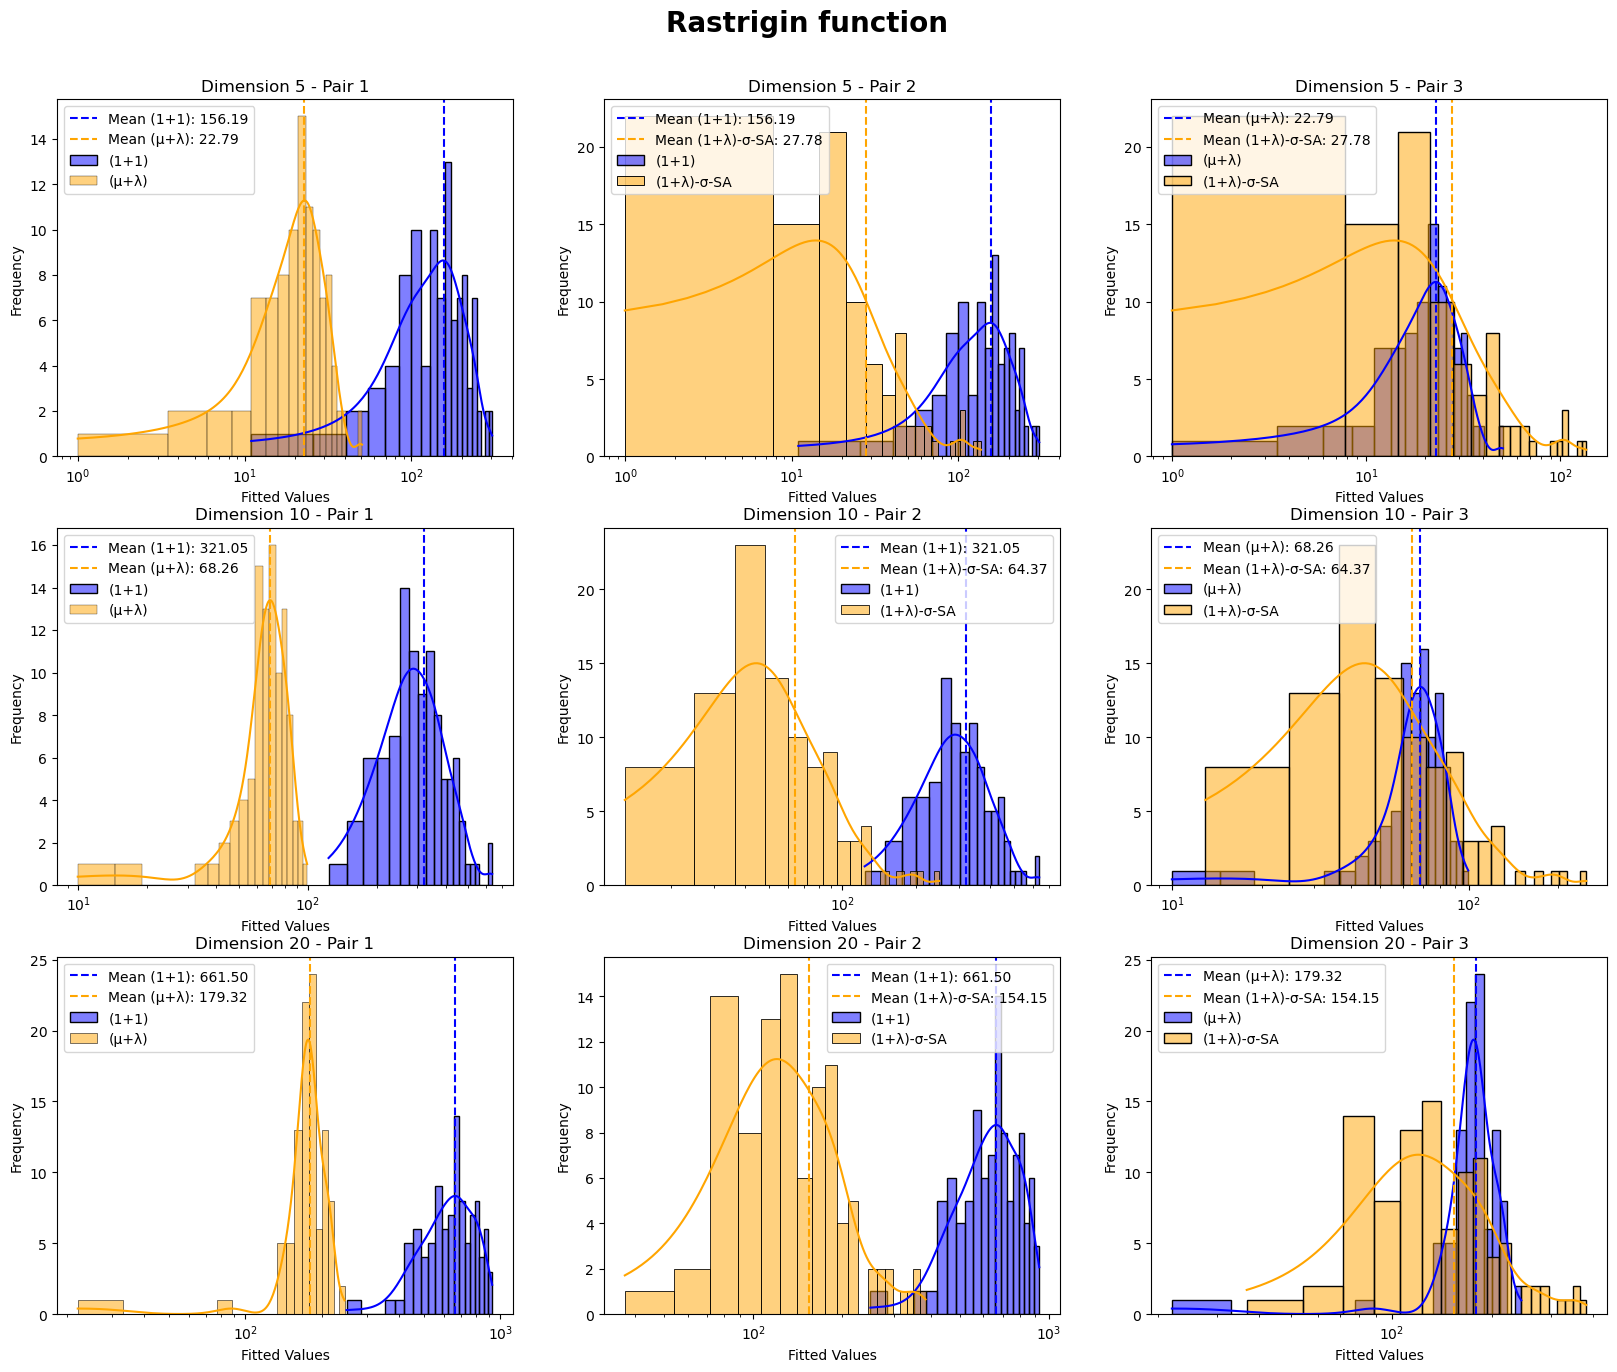

In [257]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the paired distributions for each pair for each dimension
paired_distributions = [
    paired_dist_1_1_mu_rho_lambda,
    paired_dist_1_1_one_plus_lambda,
    paired_dist_mu_rho_lambda_one_plus_lambda
]

# Define the number of bins for the histograms
n_bins = 20

# Create subplots for each pair of distributions
fig, axs = plt.subplots(nrows=len(dim_values), ncols=len(paired_distributions), figsize=(20, 15),
                        gridspec_kw={'top': 0.92})

# Loop through each dimension and each pair of distributions
for dim_idx, dim in enumerate(dim_values):
    for pair_idx, pair in enumerate(paired_distributions):
        ax = axs[dim_idx, pair_idx]
        
        
        if pair_idx == 0: 
            sns.histplot(pair[dim_idx][0], bins=n_bins, kde=True, color='blue', ax=ax, label='(1+1)', alpha=0.5)
            sns.histplot(pair[dim_idx][1], bins=n_bins, kde=True, color='orange', ax=ax, label='(μ+λ)', alpha=0.5)

            # Calculate and plot mean lines
            mean_1_1 = np.mean(pair[dim_idx][0])
            mean_mu_lambda = np.mean(pair[dim_idx][1])
            
            print(f'Mean (1+1)    {mean_1_1},    Mean (μ+λ):    {mean_mu_lambda}')
            print("")
            
            ax.axvline(mean_1_1, color='blue', linestyle='--', label=f'Mean (1+1): {mean_1_1:.2f}')
            ax.axvline(mean_mu_lambda, color='orange', linestyle='--', label=f'Mean (μ+λ): {mean_mu_lambda:.2f}')

            # Set labels and titles
            ax.set_xlabel('Fitted Values')
            ax.set_ylabel('Frequency')
            ax.set_title(f"Dimension {dim} - Pair {pair_idx + 1}")
            ax.legend()

            # Rescale x-axis with logarithmic scale
            ax.set_xscale('log')
        elif pair_idx == 1: 
            sns.histplot(pair[dim_idx][0], bins=n_bins, kde=True, color='blue', ax=ax, label='(1+1)', alpha=0.5)
            sns.histplot(pair[dim_idx][1], bins=n_bins, kde=True, color='orange', ax=ax, label='(1+λ)-σ-SA', alpha=0.5)

            # Calculate and plot mean lines
            mean_1_1 = np.mean(pair[dim_idx][0])
            mean_mu_lambda = np.mean(pair[dim_idx][1])
            
            print(f'Mean (1+1)    {mean_1_1},    Mean (1+λ)-σ-SA:    {mean_mu_lambda}')
            print("")
            
            ax.axvline(mean_1_1, color='blue', linestyle='--', label=f'Mean (1+1): {mean_1_1:.2f}')
            ax.axvline(mean_mu_lambda, color='orange', linestyle='--', label=f'Mean (1+λ)-σ-SA: {mean_mu_lambda:.2f}')

            # Set labels and titles
            ax.set_xlabel('Fitted Values')
            ax.set_ylabel('Frequency')
            ax.set_title(f"Dimension {dim} - Pair {pair_idx + 1}")
            ax.legend()

            # Rescale x-axis with logarithmic scale
            ax.set_xscale('log')
        else:
            sns.histplot(pair[dim_idx][0], bins=n_bins, kde=True, color='blue', ax=ax, label='(μ+λ)', alpha=0.5)
            sns.histplot(pair[dim_idx][1], bins=n_bins, kde=True, color='orange', ax=ax, label='(1+λ)-σ-SA', alpha=0.5)

            # Calculate and plot mean lines
            mean_1_1 = np.mean(pair[dim_idx][0])
            mean_mu_lambda = np.mean(pair[dim_idx][1])
            
            
            print(f'Mean (μ+λ)    {mean_1_1},        Mean (1+λ)-σ-SA:    {mean_mu_lambda}')
            print("")
            print("")
            
            ax.axvline(mean_1_1, color='blue', linestyle='--', label=f'Mean (μ+λ): {mean_1_1:.2f}')
            ax.axvline(mean_mu_lambda, color='orange', linestyle='--', label=f'Mean (1+λ)-σ-SA: {mean_mu_lambda:.2f}')

            # Set labels and titles
            ax.set_xlabel('Fitted Values')
            ax.set_ylabel('Frequency')
            ax.set_title(f"Dimension {dim} - Pair {pair_idx + 1}")
            ax.legend()

            # Rescale x-axis with logarithmic scale
            ax.set_xscale('log')

    
# Adjust layout
fig.tight_layout()
fig.suptitle('Rastrigin function', fontsize=20, fontweight='bold')

# Show the plot
plt.show()


#5 dim:

# (1+lambda), (mu+lambda)  - 1,2
# 1+1 - 3

#10 dim
# (1+lambda) - 1 
# (mu+lambda)  - 2 (5% sign.)
# 1+1 - 3

#20 dim
# (1+lambda) - 1 
# (mu+lambda)  - 2 (any lvl)
# 1+1 - 3